# PCA eigenfaces

#### Goal: Visualize the first few principal components of face images and compress images by projecting onto the first k principle components.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
%matplotlib inline  

### Load and preprocess images

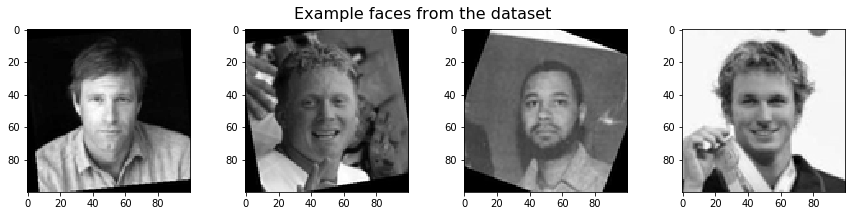

In [2]:
counter = 0
cwd = os.getcwd()
faces_list = []
fig, axs = plt.subplots(1,4,figsize=(15,3))
for dirpath, dirnames, filenames in os.walk(cwd): #  + "/LFW_faces"
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        counter = counter + 1
        cur_file_fullpath = os.path.join(dirpath, filename) # Get full file path of .jpg files
        cur_img = Image.open(cur_file_fullpath) # Open image
        cur_img = cur_img.resize((100,100), Image.ANTIALIAS) # Resize to 100x100 pixels
        cur_img = np.array(cur_img) # Convert to array type
        cur_img = color.rgb2gray(cur_img) # Convery to greyscale
        if counter < 5: # plot 4 faces. faces pixel values range from 0-1
            ax = plt.subplot(1,4,counter)
            plt.imshow(cur_img, cmap='gray')
        cur_img = cur_img.flatten() # Linearize
        faces_list.append(cur_img) # Append file data to a list
fig.suptitle("Example faces from the dataset", fontsize=16)
faces_matrix = np.vstack(faces_list) # Convert list of individual data file to data matrix

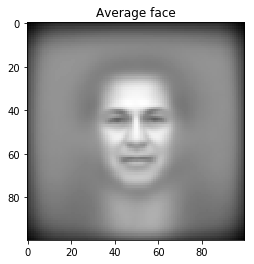

In [3]:
# Show the average face, and center data
avg_face = np.mean(faces_matrix,axis=0)
plt.imshow(avg_face.reshape(100,100),cmap='gray'); 
plt.title('Average face')
faces_matrix_centered = faces_matrix-avg_face

### PCA by eigenvalue decomposition

In [4]:
# Calculate covariance matrix
face_cov = np.cov(faces_matrix_centered.T) #np.cov expects features as rows and observations as columns, so transposed

In [5]:
# Calculate eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(face_cov)

In [6]:
# Sort eigenvectors and eigenvalues
idx = eigen_vals.argsort()[::-1]   
eigen_vals_sorted = eigen_vals[idx]
eigen_vecs_sorted = eigen_vecs[:,idx]

Text(0.5,0.98,'First 10 eigenfaces')

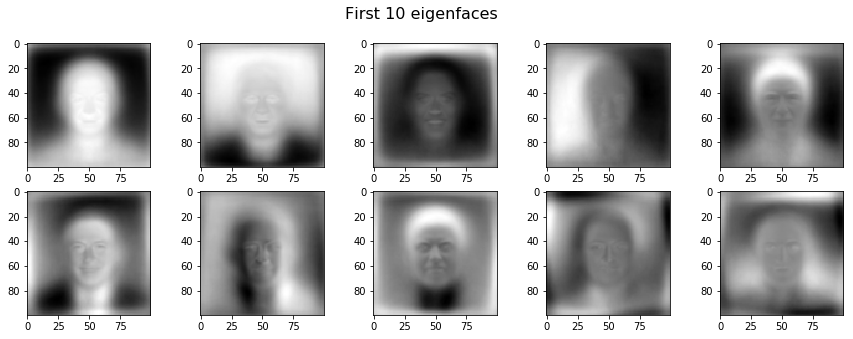

In [7]:
# Visualize first 10 PCs / eigenfaces
fig, axs = plt.subplots(2,5,figsize=(15,5))
for i in np.arange(10):
    ax = plt.subplot(2,5,i+1)
    cur_img = eigen_vecs[:,i].reshape(100,100)
    plt.imshow(cur_img, cmap='gray');
fig.suptitle("First 10 eigenfaces", fontsize=16)

### Reconstruction with increasing k eigenfaces

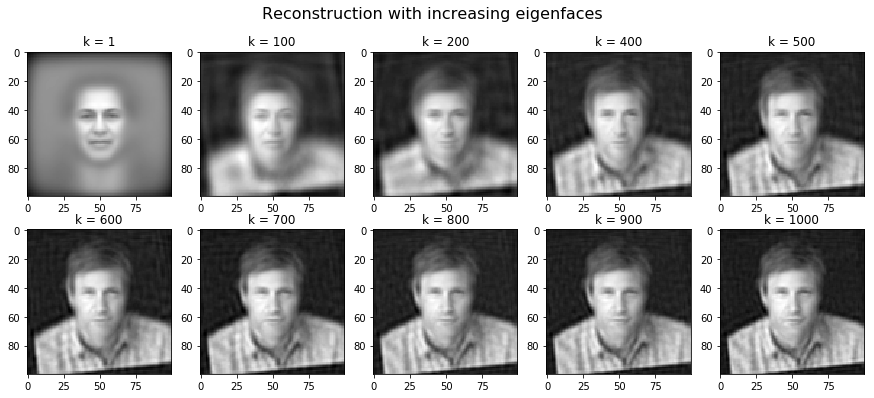

In [8]:
fig, axs = plt.subplots(2,5,figsize=(15,6))
for k, i in zip([0,99,199,399,499,599,699,799,899,999],np.arange(10)):
    face_score = faces_matrix_centered[0,:].dot(eigen_vecs[:,:k]) # Get PC scores of the images
    projected_face = face_score.dot(eigen_vecs[:,:k].T) # Reconstruct first face in dataset using k PCs
    ax = plt.subplot(2,5,i+1)
    ax.set_title("k = "+str(k+1))
    plt.imshow(projected_face.reshape(100,100)+avg_face.reshape(100,100),cmap='gray');
fig.suptitle(("Reconstruction with increasing eigenfaces"), fontsize=16);

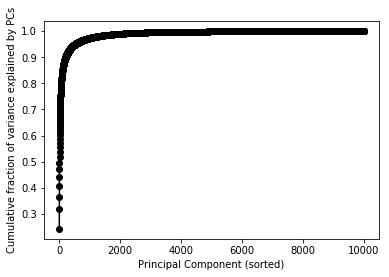

In [9]:
# Cumulative fraction of variance explaineded by PCs
eigen_vals_sorted_cum = np.cumsum(eigen_vals_sorted)/sum(eigen_vals_sorted)
plt.plot(eigen_vals_sorted_cum,marker='o',color='k');
plt.xlabel('Principal Component (sorted)')
plt.ylabel('Cumulative fraction of variance explained by PCs');

In [10]:
# First 1000 PCs explain 97% of variance
eigen_vals_sorted_cum[1000]

0.9741135854301564

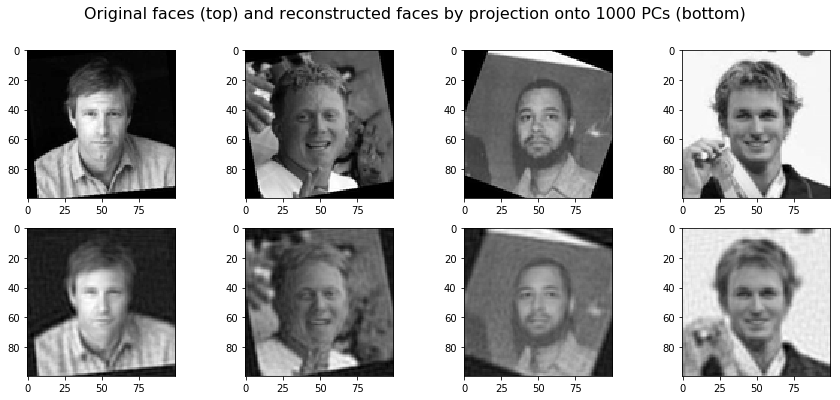

In [11]:
# Reconstructing the first 4 faces in the dataset using the first 1000 PCs
PC_reduced = 1000
num_faces = 4
selected_faces = faces_matrix_centered[:num_faces,:] # filter to relevant data
face_scores = selected_faces.dot(eigen_vecs[:,:PC_reduced]) # Get PC scores of the images
projected_faces = face_scores.dot(eigen_vecs[:,:PC_reduced].T) # Project faces on reduced PCs

# Plot projected faces
fig, axs = plt.subplots(2,4,figsize=(15,6))
for i in np.arange(num_faces):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(faces_matrix[i,:].reshape(100,100),cmap='gray'); # show the original
    ax = plt.subplot(2,4,i+1+num_faces)
    plt.imshow(projected_faces[i,:].reshape(100,100)+avg_face.reshape(100,100),cmap='gray');
fig.suptitle(("Original faces (top) and reconstructed faces by projection onto " + str(PC_reduced) + " PCs (bottom)"), fontsize=16);

### Reconstructing an image not in the original dataset

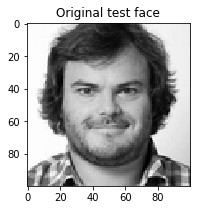

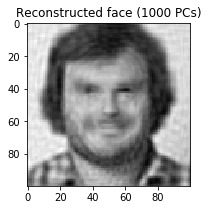

In [12]:
# Load test image
cur_img = Image.open('Jack-Black.png') # Open test image (.png files excluded from original data loading set)
cur_img = cur_img.resize((100,100), Image.ANTIALIAS) # Resize to 100x100 pixels
cur_img = np.array(cur_img) # Convert to array type
cur_img = color.rgb2gray(cur_img) # Convery to greyscale
cur_img = cur_img.flatten() # Linearize
plt.figure(figsize=(3,3))
plt.imshow(cur_img.reshape(100,100),cmap='gray')
cur_img = cur_img - avg_face
plt.title('Original test face')
plt.show()

# Project and reconstruct from reduced PCs
test_face_scores = cur_img.dot(eigen_vecs[:,:PC_reduced]) # Get PC scores of the image
test_projected_faces = test_face_scores.dot(eigen_vecs[:,:PC_reduced].T) # Project faces on reduced PCs
plt.figure(figsize=(3,3))
plt.imshow(test_projected_faces.reshape(100,100)+avg_face.reshape(100,100),cmap='gray');
plt.title('Reconstructed face (' + str(PC_reduced) + " PCs)")
plt.show()

### Footnote: PCA by Singular Value Decomposition as an alternative

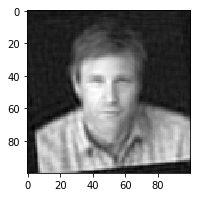

In [13]:
U, Sigma, VT = np.linalg.svd(faces_matrix_centered.T, full_matrices=False) 
# where U are the eigenvectors, and Sigma^2 are linearly correlated with eigenvalues, both are already sorted coming out of SVD
face_score_U = faces_matrix_centered[0,:].dot(U[:,:1000]) # Get PC scores of the image
projected_face_U = face_score_U.dot(U[:,:1000].T) # Reconstruct first face in dataset
plt.figure(figsize=(3,3))
plt.imshow(projected_face_U.reshape(100,100)+avg_face.reshape(100,100), cmap='gray');